# Sentiment Analysis/Text classification

Dataset source: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

## Load the libraries

Libraries used are:
- pandas
- sklearn (to create our prediction model)
- Flask (as back-end of our web app)
- waitress (to run the Flask web app)
- pymongo (to communicate with mongodb database)
- matplotlib (to visualize/plot the data)
- wordcloud (to visualize text data)
- nltk (to deal with text, natural language toolkit :https://www.nltk.org/install.html)

We also need to download the English data from https://www.nltk.org/data.html

```
python -m nltk.downloader popular
```

*Notes:*
- The MongoDB will be used to store the dataset as well as the future prediction results.
- Make sure you have mongodb installed in your VM if you are working with your own VM instance or use the MongoDB provided in this class.
- A MongoDB instance address will be shared in the class.

If you've installed them, you can directly install all of the libraries by running the below command:

In [ ]:
# download the NLTK data 
# 'popular' can be change to specific individual data or 'all' to download all the NLTK data
!python -m nltk.downloader popular

In [ ]:
!pip install pandas sklearn Flask waitress pymongo matplotlib nltk wordcloud

In [ ]:
# import the modules/libraries
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
# NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#stemming
from nltk.stem import PorterStemmer
#lemmatization
from nltk.stem import WordNetLemmatizer 
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing

# suppress all warnings (ignore unnecessary warnings msgs)
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [ ]:
df = pd.read_csv('Tweets.csv') #read the "Tweets.csv" file and assign it to df variable

In [ ]:
df.head() # show the first 5 data

**For this case, we will only use 200 data to speed up the process**

In [ ]:
df = df[:200]
df.shape

In [ ]:
# here we just need the data from column "airline_sentiment" as the output 
# and "text" as the input
# so we will just take those only

df_input = df['text'] # text data only
df_output = df['airline_sentiment'] #class or label output

In [ ]:
df_input.head() # show the first 5 data

In [ ]:
df_output.head() # show the first 5 data

## Data pre-processing

Including removing stop words, tokenize, stemming, label encoder, etc

In [ ]:
# df_input is the text in the form of dataframe
# df_ouput is the airline_sentiment label (target output/class)
def text_preprocessing_stem(df_input, df_output):
    # initiate empty list for storing the preprocessed text data
    processed_data = list()
    # initiate stemmer, https://www.nltk.org/howto/stem.html
    stemmer = PorterStemmer()
    lemma = WordNetLemmatizer()
    # loop for each text in the dataset, row by row (one by one)
    for row in df_input.values.tolist():
        # tokenize the text
        tokens = word_tokenize(row)
        # convert the tokens into lowercase
        tokens = [w.lower() for w in tokens]
        # check alphabhet
        tokens = [word for word in tokens if word.isalpha()]
        # remove the stopword
        tokens = [word for word in tokens if not word in stopwords.words()]
        # apply stemming
        #tokens = [stemmer.stem(word) for word in tokens]
        # or apply Lemmatization
        tokens = [lemma.lemmatize(word) for word in tokens]
        #print(tokens)
        # append the preprocessed text into processed_data (list)
        processed_data.append(tokens)
    
    # check the content of processed_data
    print(processed_data[:3]) # show 3 data
    
    # initiate label_Encoder
    label_encoder = preprocessing.LabelEncoder()
    # fit the encoder to the df_output
    label_encoder.fit(df_output)
    # transform the df_output using LabelEncoder
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    Y_output = label_encoder.transform(df_output)
    
    # create new document
    new_doc = list()
    for text in processed_data:
        row = ' '.join(text)
        new_doc.append(row)
        
    # return the new_doc and Y_output
    return new_doc, Y_output
    

In [ ]:
# call text_preprocessing function
new_doc, Y_output = text_preprocessing(df_input, df_output)

In [ ]:
new_doc[:3] # show first 3 data

In [ ]:
Y_output

## Word cloud (we can visualize the frequent word in our dataset using word cloud)

- A word cloud is a collection, or cluster, of words depicted in different sizes
- The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.
- https://amueller.github.io/word_cloud/index.html
- https://pypi.org/project/wordcloud/


In [ ]:
from wordcloud import WordCloud

alltext = ' '.join(new_doc)
wordcloud = WordCloud(width=800, height=800, background_color="white")
wordcloud = wordcloud.generate_from_text(alltext)

# display the generated image
plt.figure(figsize=(8,9), dpi=100)
plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
plt.show()

## Vectorize the data with BOW (Bag of Words)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def BOW_vector(new_doc):
    vectorizer_bow = CountVectorizer(max_features=1000)
    X_input = vectorizer_bow.fit_transform(new_doc)
    #print(vectorizer_bow.vocabulary_)
    return X_input, vectorizer_bow.vocabulary_

In [ ]:
X_input, vocabulary = BOW_vector(new_doc)
X_input.toarray() # the vectorized input data

## Apply the Machine Learning Model

In [ ]:
def apply_MLP(X_input, Y_output):
    
    #Split the data into train and test for each X and y; 
    # test_size=0.3 means 30% for test data and the rest for training
    X_train, X_test, y_train, y_test = train_test_split(X_input, Y_output, random_state=0, test_size=0.3)
    
    # apply MLP algorithm
    # initiate the classifier/model
    model = MLPClassifier(random_state=0) 

    # training the model/classifier with training data (X_train and y_train)
    model = model.fit(X_train, y_train)
    
    return model

In [ ]:
# Evaluate the model performance
def evaluate_model(model):
    # predict the X_test
    y_pred = model.predict(X_test) 
    #print(y_pred)
    
    # confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    # calculate accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    # calculate precision, apply average since it's multiclass
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    #calculate recall, apply average since it's multiclass
    recall = metrics.recall_score(y_test, y_pred, average='macro') 

    # print / show the output
    print("Confusion Matrix:", confusion_matrix)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

### Evaluate the performance of BOW and MLP

In [ ]:
X_input, vocabulary = BOW_vector(new_doc)
model = apply_MLP(X_input, Y_output)
evaluate_model(model)

In [ ]:
#vocabulary

## Vectorize the data with TF-IDF

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF_vector(new_doc):
    vectorizer_tfidf = TfidfVectorizer(max_features=1000)
    X_input = vectorizer_tfidf.fit_transform(new_doc)
    #print(vectorizer_tfidf.vocabulary_)
    return X_input, vectorizer_tfidf.vocabulary_

### Evaluate the performance of TF-IDF and MLP

In [ ]:
X_input, vocabulary = TFIDF_vector(new_doc)
model = apply_MLP(X_input, Y_output)
evaluate_model(model)

## Export the vocabulary and prediction model into FILENAME.model file

In [ ]:
# save the model using joblib
import joblib

# export the vocabulary
vocab_filename = "tfidf-vocab.model"
joblib.dump(vocabulary, vocab_filename)

# export the model
model_filename = "MLP-tfidf.model"
joblib.dump(model, model_filename)

## Import the prediction model and use it to predict with new data

In [ ]:
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# initiate transformer
tfidf_transformer = TfidfTransformer()

# import the vocabulary
vocab_filename = "tfidf-vocab.model"
loaded_vocab = joblib.load(vocab_filename)

# import the model
model_filename = "MLP-tfidf.model"
loaded_model = joblib.load(model_filename)

# new unlabelled sentence
new_sentence = "The flight was good and I love the food served!" # positive
#new_sentence = "The flight was horrible and the food was really bad!" # negative
#new_sentence = "The price is affordable." # normal

# load the vector
loaded_vector = TfidfVectorizer(vocabulary=loaded_vocab)
# convert / preprocess the new_sentence into tfidf vector
input_vector = loaded_vector.fit_transform(np.array([new_sentence]))
tfidf_input = tfidf_transformer.fit_transform(input_vector)

# predict the label
new_sentence_pred = loaded_model.predict(tfidf_input)

if new_sentence_pred[0] == 0:
    output = "Negative"
elif new_sentence_pred[0] == 1:
    output = "Neutral"
elif new_sentence_pred[0] == 2:
    output = "Positive"
else:
    output = "Undefined"

print(new_sentence_pred)
print("Predicted as", output)

## Store the new_sentence and it's prediction output into MongoDB

In [ ]:
import datetime

# 127.0.0.1 is the local mongodb address installed
client = MongoClient('mongodb://127.0.0.1:27017/')

# YOU SHOULD change '<<yourUSERNAME>>' with userSTUDENTID (for example: user22222)
db = client['<<yourUSERNAME>>'] #<<yourUSERNAME>>

#text_prediction is the collection (table) name in our mongodb database
text_prediction = db['text_prediction']

# new record data, formatted in json
new_record = { 
    'sentence': new_sentence, 
    'output': output, 
    'created_at': datetime.datetime.now()
}

# Insert one record
text_prediction.insert_one(new_record)

## Retrieve text_predictions data from MongoDB

In [ ]:
# get username
import getpass
username = getpass.getuser()

username # username will be used for your MongoDB Database Name

In [ ]:
# 127.0.0.1 is the local mongodb address installed
client = MongoClient('mongodb://127.0.0.1:27017/')

# YOU SHOULD change '<<yourUSERNAME>>' with userSTUDENTID (for example: user22222)
db = client['<<yourUSERNAME>>'] # <<yourUSERNAME>>

#text_prediction is the collection (table) name in our mongodb database
text_prediction = db['text_prediction']

# retrieve last 5 data (limit = 5)
# sort by _id, -1 -> desc; 1 -> asc
last_predictions_results = text_prediction.find().sort("_id", -1).limit(5)

#print the result:
for data in last_predictions_results:
    created_at = data['created_at']
    date_time = created_at.strftime("%d/%m/%Y, %H:%M:%S")
    sentence = data['sentence']
    output = "Predicted as "+data['output']
    print(date_time, '- '+sentence, "("+output+")")

## Now let's create a web app so that it can be useful :)

Check ```textwebapp.py``` file inside ```webapp/``` directory/folder and change the port number.

First you need to copy all the models file into ```webapp/``` directory/folder, by executing the following command:

In [ ]:
!cp $vocab_filename $model_filename webapp/

After that you can start/execute the ```textwebapp.py``` via here (jupyter notebook):

In [ ]:
# check the current working directory
!pwd

Move to ```webapp``` directory and execute the ```textwebapp.py``` file

In [ ]:
!cd webapp && python textwebapp.py

or via terminal (make sure you're in the ```webapp``` directory) by typing: ``` python textwebapp.py ```

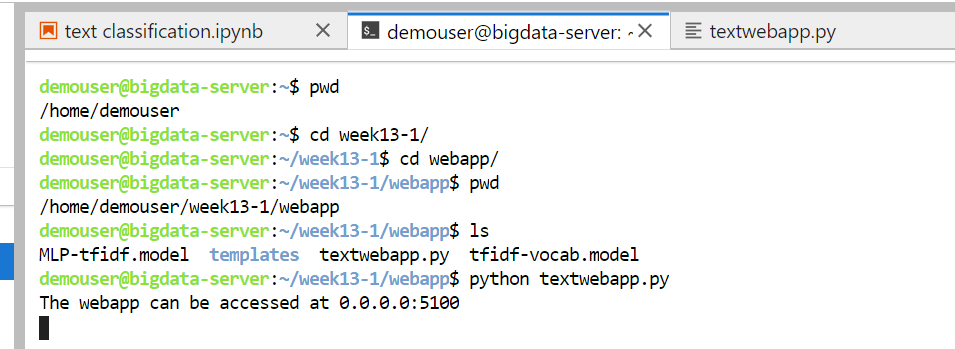